# Simple Gaussian objects

The main purpose of this library is to make Gaussian manipulations easy. For this we make use of a _certain hierarchy of function classes_.

##### ```GaussianPDF``` $\subset$ ```GaussianMeasure``` $\subset$ ```ConjugateFactor```

This three function classes are explained in the following:



$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bnu}{\boldsymbol{\nu}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bY}{\mathbf{Y}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\diff}{\mathrm{d}}$

## 1. `ConjugateFactor`:

The `ConjugateFactor` is the most general form of functions of the considered hierarchy. It has the following functional form:

$$
u(X) = \exp\left(-\frac{1}{2}X^\top\Lambda X + X^\top\bnu + \ln \beta\right)
$$

The parameters are as follows:
+ $\Lambda\in \RR^{d\times d}$ is a positive semidefinite matrix.
+ $\bnu\in \RR^d$ is a vector.
+ $\ln\beta\in \RR$ is a constant.

Let's create such an examplary object with the Gaussian toolbox in two dimensions and visualize it.

In [1]:
# Imports
from matplotlib import pyplot as plt
from jax import numpy as jnp
from objax import random

In [2]:
from gaussian_toolbox.gaussian_algebra import factor

# Create plot grid
reso = 70
xrange = jnp.linspace(-5,5,reso)
xmesh, ymesh = jnp.meshgrid(xrange, xrange)
x = jnp.vstack([xmesh.flatten(), ymesh.flatten()]).T

# Define terms for factor
Lambda_u = jnp.array([[[5,0],
                       [0,0]]])
nu_u = jnp.array([[0,0]])
ln_beta_u = jnp.array([0,])

# Create factor u(x)
u_X = factor.ConjugateFactor(Lambda=Lambda_u, nu=nu_u, ln_beta=ln_beta_u)
print(u_X)

Conjugate factor u(x)


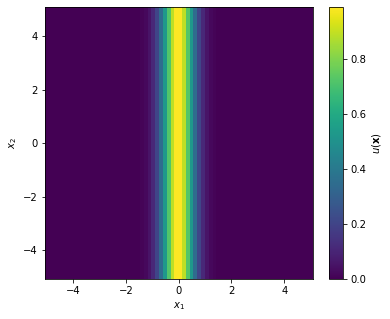

In [3]:
u_x = u_X(x)

# Plotting
plt.figure(figsize=(6,5))
plt.pcolor(xrange, xrange, u_x.reshape((reso,reso)), shading='nearest')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$u(\mathbf{x})$')
plt.show()

__Remark__: It is possible to summarize more than one Factor in an object. The number of factor is equal to the leading dimensions of `Lambda`, `nu` and `ln_beta`.

With a `ConjugateFactor` on its own we can not do very much, but we will see how it can unfold its power in combination with a `GaussianMeasure`.


## 2. `GaussianMeasure`

A `GaussianMeasure` inherits from `ConjugateFactor`, i.e. it is a subclass of what we saw previously. It has the functional form

$$
\phi(X) = \exp\left(-\frac{1}{2}X^\top\Lambda \bX + X^\top\bnu + \ln \beta\right)
$$

All is defined as before, except that $\Lambda$ is now required to be positive definite, such that

$$
0 \leq \int \phi(X)\diff X < \infty.
$$

Again let's create such an object with the Gaussian toolbox.

In [4]:
from gaussian_toolbox.gaussian_algebra import measure

# Defines terms for measure
Lambda_phi = jnp.array([[[1., -2.],
                         [-2., 10.]]])
nu_phi = jnp.array([[0, 0]])
ln_beta_phi = jnp.array([0,])

# Creates measure
phi_X = measure.GaussianMeasure(Lambda=Lambda_phi, nu=nu_phi, ln_beta=ln_beta_phi)
print(phi_X)

Gaussian measure phi(x)


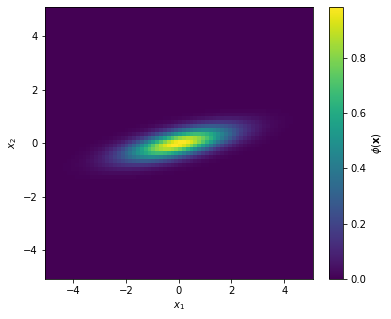

In [5]:
phi_x = phi_X(x)

plt.figure(figsize=(6,5))
plt.pcolor(xrange, xrange, phi_x.reshape((reso,reso)), shading='nearest')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$\phi(\mathbf{x})$')
plt.show()

### Leveraging conjugacy

Now the interesting observation is that the `ConjugateFactor` multiplied with a `GaussianMeasure` is again a `GaussianMeasure`, i.e. the first is _conjugate_ to the latter. The Gaussian toolbox allows for straightforward updates.

In [6]:
u_phi_X = phi_X * u_X
print(u_phi_X)

Gaussian measure phi(x)


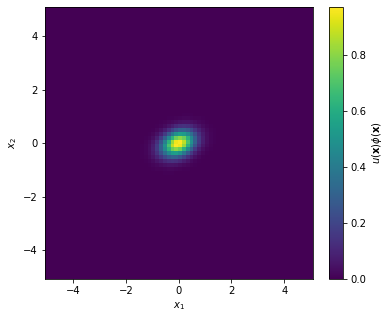

In [7]:
u_phi_x = u_phi_X(x)

plt.figure(figsize=(6,5))
plt.pcolor(xrange, xrange, u_phi_x.reshape((reso,reso)), shading='nearest')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$u(\mathbf{x})\phi(\mathbf{x})$')
plt.show()

### Integration made easy

The Gaussian toolbox implements many different integrals that are evaluated with respect to a `GaussianMeasure` $\phi(X)$. The integrals have the form

$$
\int f(X)\diff\phi(X)
$$

For example $\int XX^\top\diff\phi(X)$ is evaluated as

In [8]:
print(phi_X.integrate("xx'"))

[[[4.2751656  0.8550331 ]
  [0.8550331  0.42751655]]]


Another example would be $\int (AX+a)\diff\phi(X)$, where $A\in\RR^{m\times d}$ and $a\in\RR^{m}$.

In [9]:
m = 5
A_mat, a_vec = random.normal((m, phi_X.D)), random.normal((m, ))
print(phi_X.integrate("(Ax+a)", A_mat=A_mat, a_vec=a_vec))

[[ 2.3901758  -0.01035065 -4.221131   -3.6609485   2.718234  ]]


Following integrals are implemented:

In [10]:
print(''.join(['f(X) = ' + integral + '\n' for integral in phi_X.integration_dict.keys()]))

f(X) = 1
f(X) = x
f(X) = (Ax+a)
f(X) = xx'
f(X) = (Ax+a)'(Bx+b)
f(X) = (Ax+a)(Bx+b)'
f(X) = (Ax+a)(Bx+b)'(Cx+c)
f(X) = (Ax+a)'(Bx+b)(Cx+c)'
f(X) = x(A'x + a)x'
f(X) = xb'xx'
f(X) = (Ax+a)'(Bx+b)(Cx+c)'(Dx+d)
f(X) = (Ax+a)(Bx+b)'(Cx+c)(Dx+d)'
f(X) = log u(x)



The last case is the integral of the logarithm of a `ConjugateFactor`

In [11]:
print(phi_X.integrate("log u(x)", factor=u_X))

[-10.687914]


It is time to turn to the last functional class, the `GaussianPDF`.

## 3. `GaussianPDF`

The `GaussianPDF` is a the object representing a Gaussian probability density function (PDF), and it is defined by

$$
p(\bx) = \exp\left(-\frac{1}{2}X^\top\Lambda X + X^\top\bnu + \ln \beta\right) = \frac{1}{Z}\exp\left(-\frac{1}{2}(X-\bmu)^\top\Sigma^{-1} (X-\bmu)\right) \text{ s.t. } \int\diff p(X) \stackrel{!}{=} 1.
$$

The parameters are defined as

+ $\Sigma=\Lambda^{-1}$ is the covariance matrix
+ $\bmu=\Lambda^{-1}\bnu$ is the mean.
+ $\ln\beta= -\frac{1}{2}\ln |2\pi\Lambda^{-1}| -\frac{1}{2}\bnu^\top\Lambda^{-1}\bnu\Leftrightarrow \ln Z = \frac{1}{2}\ln |2\pi\Sigma|$ is the normalizing constant.

Any Gaussian measure can be transformed into a PDF just by normalization. With the Gaussian toolbox this is straightforward:

In [12]:
from gaussian_toolbox.gaussian_algebra import pdf

# p_X = pdf.GaussianPDF(Sigma=..., mu=...)
p_X = phi_X.get_density()
integal_p = p_X.integrate()
print('Intergrating over density = %d. (Hurray!!!)' %integal_p)

Intergrating over density = 1. (Hurray!!!)


The `GaussianPDF` inherits all properties from `GaussianMeasure`.
but since it is a PDF, we can perform additional actions, such as sampling or marginalization.

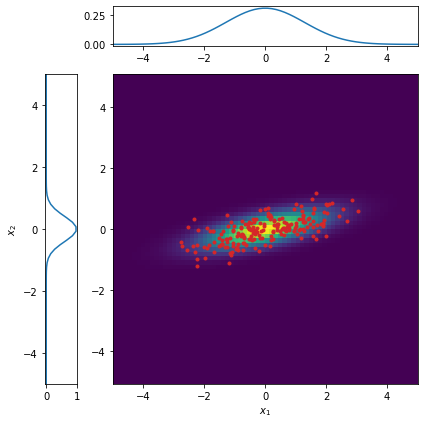

In [13]:
# SAMPLING
p_x_samples = p_X.sample(200)

# MARGINALIZATION
p_X1 = p_X.get_marginal(dim_x=jnp.array([0]))
p_X2 = p_X.get_marginal(dim_x=jnp.array([1]))

xrange = jnp.linspace(-5,5,reso)
xrange = jnp.array([xrange]).T

# Plotting
from matplotlib import gridspec
fig = plt.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax1 = fig.add_subplot(grid[1:,:1])
ax1.plot(p_X2(xrange).T, xrange)
ax1.set_ylim(xrange[jnp.array([0,-1]), 0])
ax1.set_ylabel('$x_2$')
ax2 = fig.add_subplot(grid[:1,1:])
ax2.plot(xrange,p_X1(xrange).T)
ax2.set_xlim([-5,5])
ax1.set_ylim(xrange[jnp.array([0,-1]), 0])
ax3 = fig.add_subplot(grid[1:,1:])
ax3.pcolor(xrange[:,0], xrange[:,0], p_X(x).reshape((reso,reso)), shading='nearest')
ax3.plot(p_x_samples[:,:,0], p_x_samples[:,:,1], 'C3.')
ax3.set_xlabel('$x_1$')
ax3.set_xlim([-5,5])
plt.tight_layout()

Let's summarize the Gaussian hierarchy

|   |  `ConjugateFactor` $u$ | `GaussianMeasure` $\phi$ | `GaussianPDF` $p$ |
|---|---|---|---|
| __Conjugacy__ | &check; | &check;  | &check; |
| __Integrable__  | &cross; | &check;  | &check;  |
| __Normalized__  | &cross; | &cross;  | &check;  |

In the following, we will see how the true power of the toolbox can be unleashed by introducing `conditional`